# Aula 18 - otimização bayesiana

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) Introdução
- 2) Otimização bayesiana

Na parte prática da aula de hoje, usaremos a biblioteca [hyperopt](http://hyperopt.github.io/hyperopt/)

Para instalá-la, o de sempre:

`pip install hyperopt`

__________

In [1]:
import numpy  as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

def metricas_classificacao(estimator, X_train, X_test, y_train, y_test):
    
    # ============================================

    print("\nMétricas de avaliação de treino:")

    y_pred_train = estimator.predict(X_train)

    print(confusion_matrix(y_train, y_pred_train))

    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
    plt.show()

    print(classification_report(y_train, y_pred_train))

    # ============================================

    print("\nMétricas de avaliação de teste:")

    y_pred_test = estimator.predict(X_test)

    print(confusion_matrix(y_test, y_pred_test))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    plt.show()

    print(classification_report(y_test, y_pred_test))

____
____
_____

## 1) Introdução

Desde que conhecemos os primeiros estimadores utilizados para a construção de modelos, uma preocupação adicional nos acompanhou: o ajuste de valores dos hiperparâmetros.

Quase todos os estimadores que conhecemos têm um ou mais **hiperparâmetros** associados.

Como vimos, os hiperparâmetros influenciam o comportamento do modelo (e, portanto, são muito importantes), mas eles não são determinados a partir dos dados! É nosso dever, como cientistas de dados, fornecer valores adequados para os hiperparâmetros.

No começo de nossa jornada, nós utilizávamos os valores default para os hiperparâmetros, ou então, mudávamos manualmente alguns valores, para sensibilizar a influência dos hiperparâmetros no modelo final.

Mas logo percebemos que essa não era a melhor abordagem --- precisávamos de um método mais sistemàtico para a busca de bons valores para os hiperparâmetros!

_______

Para este fim, introduzimos inicialmente o **grid search**, que **testa exaustivamente** combinações explícitas de valores de hiperparâmetros.

Apesar de simples e direta, esta é uma abordagem computacionalmente muito custosa (sentimos isso na pele, ao rodar rotinas de grid search que demoram horas, ou até mesmo dias!). 

De fato, esta é uma abordagem de força bruta que, aliás, não nos dá garantia nenhuma: é perfeitamente possível que nenhuma das combinações que estabelecemos seja boa boa! Oras, há muitos casos em que o **espaço de hiperparâmetros** é infinito (basta considerar um hiperparâmetro dado por um float que não é limitado).

______

Para endereçar este problema, introduzimos então o **random search**.

Neste caso, ao invés de disponibilizarmos valores específicos de hiperparâmetros a serem combinados, disponibilizamos **intervalos** ou explicitamente **distribuições de probabilidade** sobre o espaço de parâmetros de cada hiperparâmetro, e **amostramos valores aleatórios** destas distribuições para gerar as combinações.

Com essa abordagem estocástica, há a possibilidade de encontrarmos boas combinações, que não estariam inclusas nos valores explícitos que passamos para o grid search.

Por outro lado, com o random search também não temos garantia alguma que as melhores combinações serão encontradas, sobretudo porque **todas as combinações são amostradas de maneira aleatória**. Ou seja, todas as combinações são amostradas **sem considerar** a performance das combinações anteriores. Com esta metodologia, fica difícil garantirmos que efetivamente encontraremos boas combinações...

Metodologia de grid search (à esquerda) vs random search (à direita):

<img src=https://www.researchgate.net/profile/Minrui-Zheng/publication/328252103/figure/fig4/AS:766093471801344@1559662325592/Distribution-of-sampled-hyperparameters-a-grid-search-b-random-search.png width=600>

_________

Então, podemos nos perguntar: qual seria o próximo passo? Existiria um método ainda mais eficiente e "educado" para fazer a otimização de hiperparâmetros?

A resposta é: sim! Hoje, conheceremos o método de **otimização Bayesiana**, aplicada à otimização de hiperparâmetros!

_________
_________
_________

## 2) Otimização Bayesiana

O objetivo da otimização baeysiana é o mesmo que tínhamos com o grid e random search: **determinar os valores adequados para um conjunto de hiperparâmetros**, de modo que a combinação de valores **proporcione os melhores valores para uma métrica de avaliação calculada em dados de validação**.

O que muda com a otimização baeysiana é a forma como isso será feito.

Já descrevemos os problemas que ambos grid e random search têm. Sobretudo, o fato das combinações de valores dos hiperparâmetros serem independentes entre si, sem levar em consideração combinações anteriores, que poderiam ser boas.

>Pra entender isso melhor, imagine o cenário em que queremos otimizar 3 hiperparâmetros.
<br><br>
>Pode ser que, em uma combinação, encontremos bons valores para 2 dos 3 hiperparâmetros; ja, na próxima, como os 3 valores serão novos, pode ser que os 3 sejam ruins. Não seria interessante de conseguíssemos manter a informação sobre os valores bons que encontramos?

Esse é o espírito da otimização baeysiana!

Pra entender isso intuitivamente, considere a figura a seguir (suponha que o "score" é um erro, então, quanto menor, melhor):

<img src=https://miro.medium.com/max/1120/1*MiNXGrkk5BbjfkNAXZQSNA.png width=400>

Pergunta: onde você concentraria a busca por valores do hiperparâmetro `n_estimators`?

Olhando pro gráfico, existe claramente uma região no espaço do hiperparâmetro `n_estimators` que é melhor: menos de 200 árvores.

**Uma vez que temos este conhecimento**, realmente não faz sentido algum que os próximos valores que vamos testar sejam maiores que 200, não é mesmo?

Esse é o espírito da otimização bayesiana: **utilizamos a informação que temos quanto ao score alcançado com valores iniciais de hiperparâmetros para guiar a escolha dos próximos valores!**

E aqui já fica claro o porquê do método receber o título "bayesiano": de fato, estamos nos utilizando da "filosofia" bayesiana de ajuste de estratégia conforme agregamos novas informações! 

>E é por isso que a otimização bayesiana é tão mais eficiente que as estratégias anteriores: gastamos um pouco mais de energia para propor combinações de hiperparâmetros **levando em consideração** as combinações passadas e suas respectivas perfomances.
<br><br>
Com isso, podemos focar apenas em testar **combinações promissoras**, e não precisamos gastar energia em procurar por combinações que sabemos não ser tão boas.

Faz sentido, não é mesmo?

Agora, precisamos apenas entender **como** é possível implementar isso. Vamos estab

### 2.1) Função objetivo

É razoável assumirmos que existe uma função que relaciona a métrica de performance (score) que temos interesse de otimizar e os hiperparâmetros, não é mesmo?

Sabendo que as métricas de performance essencialmente comparam os targets preditos com os targets reais, e sabendo que os targets preditos (pela hipótese) são influenciados pelos hiperparâmetros, é bem natural que assumamos que esta função existe.

Agora, o ponto é que pode ser extremamente difícil escrever esta função explicitamente. Como nosso objetivo será encontrar valores que **otimizam** a função, costumamos chamá-la de **função objetivo**. 

Mas, veja, queremos otimizar uma função onjetivo **sem nem saber qual é sua dependência funcional com os hiperparâmetros**. Problemas deste tipo são chamados de **otimização de caixa-preta**, e existem várias técnicas para abordá-los. Recomendo [este material](https://www.lix.polytechnique.fr/~dambrosio/blackbox_material/Cassioli_1.pdf) aos interessados.

<img src=https://www.researchgate.net/profile/Abraham-Duarte/publication/236164556/figure/fig1/AS:393408515461120@1470807307227/Schematic-representation-of-the-black-box-optimization-framework.png width=500>

Quando formos pra prática, construiremos a função objetivo implicitamente, como o resultado retornado por uma **métrica de avaliação** dado o treinamento de um modelo. 

Na prática, isso nos será suficiente, pois bastará que tomemos **alguns pontos** desta função, para seguir com sua otimização, isso graças à introdução do surrogate model.

### 2.2) Surrogate model

Na prática, iremos apenas **avaliar alguns pontos da função objetivo** e construir um **modelo probabilístico dela** com base nestes pontos, que serão tratados como **amostras**.

Este modelo probabílistico é conhecido como **surrogate model (modelo substituto ou emulador)**, pois ele emula probabilisticamente o que seria a função real, sem a necessidade dela ser reconstruída explicitamente. E o melhor, dado que o modelo surrogate é bem mais simples que a função objetivo, será muito mais fácil otimizá-lo do que a função objetivo em si!

<img src=https://www.researchgate.net/profile/Seung-Seop-Jin-2/publication/297605027/figure/fig1/AS:339392045568000@1457928777016/Concept-of-sequential-surrogate-modelling.png width=600>

O ponto é que nosso modelo surrogate será atualizado **de maneira bayesiana**, isto é, levando em consideração scores anteriores, para sugerir as próximas combinações de hiperparâmetros de maneira mais principada.

Operacionalmente, seguiremos o seguinte passo-a-passo:

- Construiremos um modelo probabilístico surrogate para a função objetivo;
- Otimizaremos o modelo surrogate, encontrando bons valores para os hiperparâmetros nesta função;
- Utilizamos estes valores encontrados e damos de input para a função objetivo real, e amostramos um novo ponto;
- Atualizamos o modelo surrogate, incorporando o novo ponto amostrado;
- Repetimos os últimos 3 passos, até atingirmos o critério de parada (em geral, um número pré-definido de passos).


Há muitas formas possíveis para o modelo surrogate. Um método muito interessante é o que utiliza processos gaussianos. Sugiro muito a leitura [deste post interativo](https://distill.pub/2019/visual-exploration-gaussian-processes/) para conhecer um pouco mais sobre este método; e [este post](https://towardsdatascience.com/the-intuitions-behind-bayesian-optimization-with-gaussian-processes-7e00fcc898a0) para uma intuição quanto a sua aplicação como modelo surrogate da otimização bayesiana.

Na nossa implementação prática, utilizaremos o método conhecido como **Tree-structured Parzen Estimator** (TPE) para a construção do modelo surrogate.

Não nos preocuparemos com a matemática por trás do método. (Aos interessados, sugiro a leitura [deste artigo](https://www.diva-portal.org/smash/get/diva2:1223709/FULLTEXT01.pdf), que compara diferentes modelos surrogates e técnicas de otimização de hiperparâmetros, no contexto de redes neurais, embora as ideias sejam válidas no geral).

Basta sabermos o seguinte: o TPE precisa de um **threshold de score**:

<img src=https://miro.medium.com/max/1120/1*H5pyf3G115WGJwPpg65yaQ.png width=400>

Com base neste score, o método gera distribuições de probabilidade a priori, para ambos os valores de hiperparâmetros que estão acima e abaixo do threshold.

Uma vez em posse destas distribuições, o método se utiliza então de um **critério de escolha** que favorece valores dos hiperparâmetros que estão do lado do threshold que nos interessa (no caso deste exemplo, abaixo do threshold), e estes valores são propostos como os próximos hiperparâmetros a serem escolhidos.

E é assim que o TPE consegue "focar nas regiões promissoras" do espaço de hiperparâmetros. Muito legal, não é mesmo?

Mas ainda resta uma pergunta: qual é exatamente este critério de escolha das regiões? **Como**, a cada iteração, os próximos valores de hiperparâmetros são propostos, com o objetivo de minimizar a função objetivo?

Isto é feito de acordo com a chamada **função de seleção**.

### 2.3) Função de seleção

O objetivo da função de seleção é muito simples: **determinar os valores dos hiperparâmetros que são escolhidos do modelo surrogate** a cada passo.

Há vários critérios possíveis, mas o mais comum é conhecido como **Expected Improvement** (melhoria esperada), e ela é uma função do modelo surrogate. Seu uso é bem direto: **propomos novos valores de hiperparâmetros de modo que o expected improvement seja maximizado**. 

Podemos omitir aqui os detalhes matemáticos, o importante é lembrarmos que é o papel da função de seleção estabelecer o critério segundo o qual o modelo surrogate irá proporcionar os valores de hiperparâmetros a cada iteração.

E, com isso, conseguimos, a cada iteração, propor candidatos a valores de hiperparâmetros que melhoram o modelo surrogate. O registro destes valores é muito importante, para que o teorema de Bayes entre em ação!

### 2.4) Histórico de registros

O histórico de registros, que é uma tupla com **(valores de hiperparâmetros, respectivo score)** é muitíssimo importante para que seja possível a construção de um modelo surrogate que, a cada passo, melhora a descrição probabilística da função objetivo.

Isso é importante pois, quão melhor for nossa descrição da função objetivo, teremos que o passo disponibilizado pelo expected improvement irá proporcionar hiperparâmetros mais próximos do ótimo da função objetivo. 

E é aqui que o teorema de Bayes entra em ação: a partir de novas evidências (amostras do surrogate), atualizamos a nossa descrição da funcção objetivo com cada vez mais detalhes, e, assim, ela fica mais fácil de ser otimizada, sem precisar ser explicitamente construída!

<img src=https://miro.medium.com/max/1400/1*RQ-pAwQ88yC904QppChGPQ.png width=500>

<img src=https://miro.medium.com/max/1400/1*bSLAe1LCj3mMKfaZsQWCrw.png width=500>

Agora que já conhecemos todos os ingredientes importantes, podemos dizer enunciar o passo-a-passo da otimização bayesiana:

- Primeiro definimos um espaço de busca para cada um dos hiperparâmetros, impondo uma distribuição de probabilidade sobre o espaço;
- Construímos implicitamente a função objetivo, que tem como inputs os hiperparâmetros, e como output o score a ser otimizado (que será a métrica de avaliação de interesse);
- Construímos o modelo surrogate probabilístico da função objetivo;
- Construímos a função de seleção, que irá determinar os próximos valores para os hiperparâmetros a serem escolhidos do modelo surrogate;
- Atualizamos um histórico de valores de hiperparâmetros e respectivo score, que é utilizado pelo algoritmo para a atualização do modelo surrogate;
- Repetimos o processo até o critério de parada.


__________

E é isso!

Para os interessados em maiores detalhes matemáticos, recomendo fortemente [este artigo](http://proceedings.mlr.press/v28/bergstra13.pdf), e [este também](https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf), que reporta resultados incríveis a favor do uso de otimização bayesiana como alternativa aos métodos tradicionais de otimização de hiperparâmetros.

Agora, vamos ver o método funcionando na prática!

______________

In [3]:
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

from sklearn.pipeline import Pipeline

def pipe_pre_process_german(drop_not_features=["Risk"], col_target="Risk",
                             inputer_num_strategy="mean",
                             encoding="ordinal"):
    '''
    - inputer_num_strategy (str): "mean", "median";
    - encoding (str): "onehot" para OneHotEncoder; "ordinal" OrdinalEncoder;
    '''
    
    df = pd.read_csv("../datasets/german_credit_data.csv", index_col=0)

    X = df.drop(columns=drop_not_features)
    y = df[col_target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # ==========================================================

    pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy=inputer_num_strategy)),
                                  ("std", StandardScaler())])

    features_num = X_train.select_dtypes(include=np.number).columns.tolist()

    # ==========================================================

    if encoding == "onehot":
    
        pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                      ("onehot", OneHotEncoder(handle_unknown="ignore"))])
        
    elif encoding == "ordinal":
        
        pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                      ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value",
                                                                 unknown_value=-1))])
    
    else:
        
        raise ValueError("Únicos encodings disponíveis são 'ordinal' e 'onehot'")
        
        
    features_cat = X_train.select_dtypes(exclude=np.number).columns.tolist()

    # ==========================================================

    pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                         ("transf_cat", pipe_features_cat, features_cat)])

    return X_train, X_test, y_train, y_test, pre_processador

Vamos construir um modelo com os hiperparâmetros default (mas `learning_rate=0.1`)

In [4]:
X_train, X_test, y_train, y_test, pre_processador = pipe_pre_process_german(drop_not_features=["Risk"], 
                                                                            col_target="Risk",
                                                                            inputer_num_strategy="mean",
                                                                            encoding="ordinal")

In [5]:
pre_processador

ColumnTransformer(transformers=[('transf_num',
                                 Pipeline(steps=[('input_num', SimpleImputer()),
                                                 ('std', StandardScaler())]),
                                 ['Age', 'Job', 'Credit amount', 'Duration']),
                                ('transf_cat',
                                 Pipeline(steps=[('input_cat',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant')),
                                                 ('ordinal',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['Sex', 'Housing', 'Saving accounts',
                                  'Checking account', 'Purpose'])])

In [6]:
from sklearn.ensemble import GradientBoostingClassifier


Métricas de avaliação de treino:
[[163  77]
 [ 19 541]]


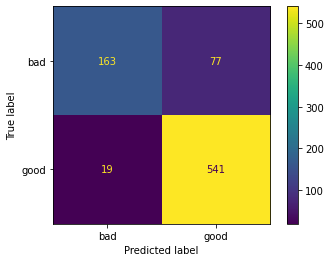

              precision    recall  f1-score   support

         bad       0.90      0.68      0.77       240
        good       0.88      0.97      0.92       560

    accuracy                           0.88       800
   macro avg       0.89      0.82      0.85       800
weighted avg       0.88      0.88      0.87       800


Métricas de avaliação de teste:
[[ 26  34]
 [ 18 122]]


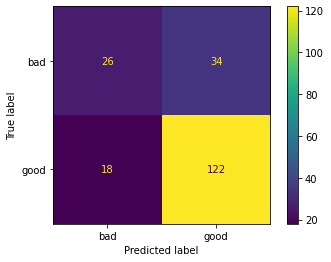

              precision    recall  f1-score   support

         bad       0.59      0.43      0.50        60
        good       0.78      0.87      0.82       140

    accuracy                           0.74       200
   macro avg       0.69      0.65      0.66       200
weighted avg       0.72      0.74      0.73       200



In [7]:
pipe = Pipeline([("pp", pre_processador),
                 ("gb", GradientBoostingClassifier(random_state=42))])

pipe.fit(X_train, y_train)

metricas_classificacao(pipe, X_train, X_test, y_train, y_test)

Nada mal. Vamos ver se conseguimos melhorar com o Grid Search:

In [11]:
np.arange(1, 6)*100

array([100, 200, 300, 400, 500])

In [8]:
pipe = Pipeline([("pp", pre_processador),
                 ("gb", GradientBoostingClassifier(random_state=42))])

params_grid = {"gb__loss" : ["deviance", "exponential"],
               "gb__n_estimators" : np.arange(1, 6)*100,
               "gb__max_depth" : [1, 2]}

splitter = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

grid_gb = GridSearchCV(pipe,
                       params_grid, 
                       cv=splitter,
                       scoring="f1_weighted",
                       verbose=10,
                       n_jobs=-1)

grid_gb.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(transformers=[('transf_num',
                                                                         Pipeline(steps=[('input_num',
                                                                                          SimpleImputer()),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Job',
                                                                          'Credit '
                                                                          'amount',
                                          

In [9]:
grid_gb.best_params_

{'gb__loss': 'exponential', 'gb__max_depth': 2, 'gb__n_estimators': 200}


Métricas de avaliação de treino:
[[144  96]
 [ 32 528]]


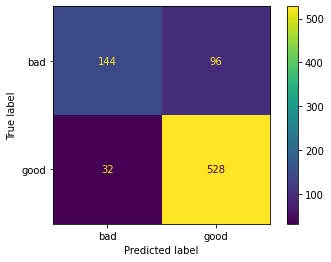

              precision    recall  f1-score   support

         bad       0.82      0.60      0.69       240
        good       0.85      0.94      0.89       560

    accuracy                           0.84       800
   macro avg       0.83      0.77      0.79       800
weighted avg       0.84      0.84      0.83       800


Métricas de avaliação de teste:
[[ 28  32]
 [ 17 123]]


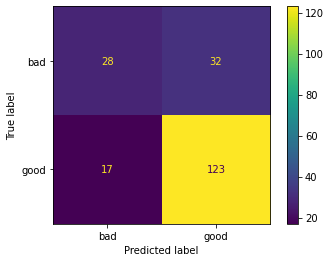

              precision    recall  f1-score   support

         bad       0.62      0.47      0.53        60
        good       0.79      0.88      0.83       140

    accuracy                           0.76       200
   macro avg       0.71      0.67      0.68       200
weighted avg       0.74      0.76      0.74       200



In [10]:
metricas_classificacao(grid_gb, X_train, X_test, y_train, y_test)

Resultado legal, melhoramos um pouco o f1.

Mas será que não dá pra melhorar ainda mais? Vamos pra otimização Bayesiana!

In [12]:
from hyperopt import hp, tpe, fmin, Trials, space_eval

Primeiramente, definimos o espaço de parâmetros. [Veja aqui](http://hyperopt.github.io/hyperopt/getting-started/search_spaces/) outras opções!

In [13]:
hps_space = {"loss" : hp.choice("loss", ["deviance", "exponential"]),
             "n_estimators" : hp.choice("n_estimators", range(1, 501)),
             "max_depth" : hp.choice("max_depth", [1, 2])}

Agora, definimos a função objetivo!

In [15]:
from sklearn.model_selection import cross_validate

In [16]:
def objective(hps_space):
    
    pipe = Pipeline([("pp", pre_processador),
                     ("gb", GradientBoostingClassifier(**hps_space))])

    # =============================================

    splitter = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

    results = cross_validate(pipe,
                             X_train, y_train, 
                             cv=splitter,
                             scoring="f1_weighted",
                             n_jobs=-1)

    mean_f1 = results["test_score"].mean()

    # como o valor vai ser minimizado, mas queremos MAXIMIZAR o f1, colocamos esse sinal negativo
    return -mean_f1

Agora, instanciamos a classe [Trials()](http://hyperopt.github.io/hyperopt/getting-started/minimizing_functions/#the-trials-object), que é a interface que nos permitirá realizar a otimização bayesiana, e que guarada o histórico, como veremos.

Note que também passamos o TPE como algoritmo para o modelo surrogate, o que é dado pelo `tpe.suggest`.

Indicamos também o número máximo de passos que queremos, com o `max_evals`.

A otimização em si é realizada com a chamada da função `fmin()`.

In [17]:
np.random.default_rng(42)

Generator(PCG64) at 0x1B956993040

In [18]:
trials = Trials()

best_hps = fmin(objective,
                space=hps_space,
                algo=tpe.suggest,
                trials=trials,
                rstate=np.random.default_rng(42),
                max_evals=10)

100%|███████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/trial, best loss: -0.7250929025867049]


In [19]:
# pré-resposta da otimização
best_hps

{'loss': 1, 'max_depth': 1, 'n_estimators': 153}

Para transformar os hiperparâmetros para a o espaço correto

In [20]:
# a resposta final, vem com o space_eval
best_hps = space_eval(hps_space, best_hps)

In [21]:
best_hps

{'loss': 'exponential', 'max_depth': 2, 'n_estimators': 154}

In [22]:
grid_gb.best_params_

{'gb__loss': 'exponential', 'gb__max_depth': 2, 'gb__n_estimators': 200}

In [23]:
GradientBoostingClassifier(**best_hps)

GradientBoostingClassifier(loss='exponential', max_depth=2, n_estimators=154)


Métricas de avaliação de treino:
[[136 104]
 [ 35 525]]


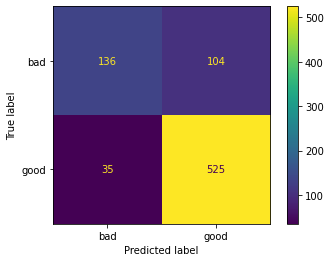

              precision    recall  f1-score   support

         bad       0.80      0.57      0.66       240
        good       0.83      0.94      0.88       560

    accuracy                           0.83       800
   macro avg       0.81      0.75      0.77       800
weighted avg       0.82      0.83      0.82       800


Métricas de avaliação de teste:
[[ 26  34]
 [ 13 127]]


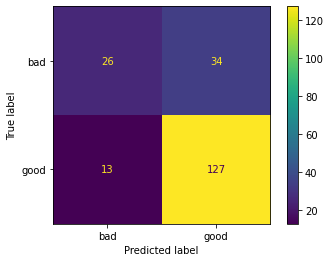

              precision    recall  f1-score   support

         bad       0.67      0.43      0.53        60
        good       0.79      0.91      0.84       140

    accuracy                           0.77       200
   macro avg       0.73      0.67      0.68       200
weighted avg       0.75      0.77      0.75       200



In [24]:
pipe = Pipeline([("pp", pre_processador),
                 ("gb", GradientBoostingClassifier(**best_hps))])

pipe.fit(X_train, y_train)

metricas_classificacao(pipe, X_train, X_test, y_train, y_test)

Brincando com a seed...

100%|███████████████████████████████████████████████| 10/10 [00:10<00:00,  1.05s/trial, best loss: -0.7264138002352106]

{'loss': 'exponential', 'max_depth': 2, 'n_estimators': 125}


Métricas de avaliação de treino:
[[129 111]
 [ 33 527]]


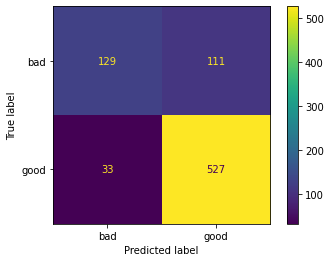

              precision    recall  f1-score   support

         bad       0.80      0.54      0.64       240
        good       0.83      0.94      0.88       560

    accuracy                           0.82       800
   macro avg       0.81      0.74      0.76       800
weighted avg       0.82      0.82      0.81       800


Métricas de avaliação de teste:
[[ 25  35]
 [ 12 128]]


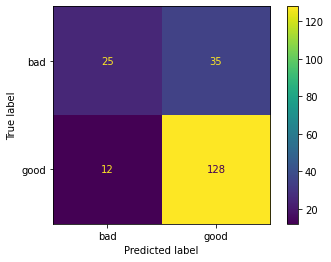

              precision    recall  f1-score   support

         bad       0.68      0.42      0.52        60
        good       0.79      0.91      0.84       140

    accuracy                           0.77       200
   macro avg       0.73      0.67      0.68       200
weighted avg       0.75      0.77      0.75       200



In [26]:
hps_space = {"loss" : hp.choice("loss", ["deviance", "exponential"]),
             "n_estimators" : hp.choice("n_estimators", range(1, 501)),
             "max_depth" : hp.choice("max_depth", [1, 2])}

trials = Trials()

best_hps = fmin(objective,
                space=hps_space,
                algo=tpe.suggest,
                trials=trials,
                max_evals=10)

best_hps = space_eval(hps_space, best_hps)

print()
print(best_hps)
print()

pipe = Pipeline([("pp", pre_processador),
                 ("gb", GradientBoostingClassifier(**best_hps))])

pipe.fit(X_train, y_train)

metricas_classificacao(pipe, X_train, X_test, y_train, y_test)

100%|███████████████████████████████████████████████| 10/10 [00:12<00:00,  1.29s/trial, best loss: -0.7234945892895522]

{'loss': 'deviance', 'max_depth': 2, 'n_estimators': 256}


Métricas de avaliação de treino:
[[157  83]
 [ 27 533]]


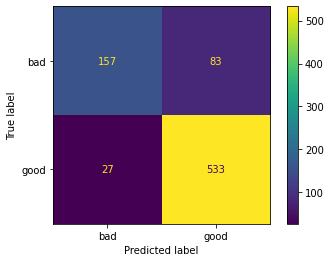

              precision    recall  f1-score   support

         bad       0.85      0.65      0.74       240
        good       0.87      0.95      0.91       560

    accuracy                           0.86       800
   macro avg       0.86      0.80      0.82       800
weighted avg       0.86      0.86      0.86       800


Métricas de avaliação de teste:
[[ 27  33]
 [ 18 122]]


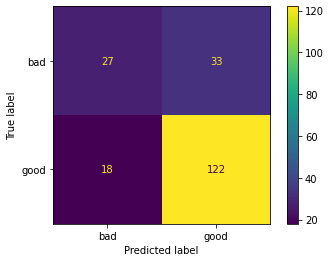

              precision    recall  f1-score   support

         bad       0.60      0.45      0.51        60
        good       0.79      0.87      0.83       140

    accuracy                           0.74       200
   macro avg       0.69      0.66      0.67       200
weighted avg       0.73      0.74      0.73       200



In [27]:
hps_space = {"loss" : hp.choice("loss", ["deviance", "exponential"]),
             "n_estimators" : hp.choice("n_estimators", range(1, 1001)),
             "max_depth" : hp.choice("max_depth", [1, 2])}

trials = Trials()

best_hps = fmin(objective,
                space=hps_space,
                algo=tpe.suggest,
                trials=trials,
                max_evals=10)

best_hps = space_eval(hps_space, best_hps)

print()
print(best_hps)
print()

pipe = Pipeline([("pp", pre_processador),
                 ("gb", GradientBoostingClassifier(**best_hps))])

pipe.fit(X_train, y_train)

metricas_classificacao(pipe, X_train, X_test, y_train, y_test)